# Prophet

- 페이스북사에서 만든 시계열 예측 모델
- PC에서는 fbprophet을 설치해야 함,  conda install -c conda-forge fbprophet
- 기존에 설치된 다른 라이브러리와 버전 문제가 생기기 쉽다. 이 때는 가상환경 (virtual env)을 하나 만들고 그 가상환경에서 설치하고 실행하면 된다.
- PC에서 설치가 안되면 colab에서 실행한다

## Prophet 장점

- prophet 모델은 현재 값 까지만 알려주고 모든 미래값을 한번에 예측한다
- walk forward 모델이 아니다 (순차적으로 미래 값을 사용하지 않는다)
- 결측치가 있어도 동작한다 (ARIMA 등 수리 모델에서는 결측치가 있으면 오류 발생)
- 세일 기간 등 특별한 이벤트를 모델 자체에 반영할 수 있다 (holiday 지정 기능 사용)

## import

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#model 관련 import 추가
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
#from Investar import Analyzer
#from Investar import MarketDB #폴더를 넣어야함. Investar


matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 15})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [18]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# 전력사용 예측

In [68]:
power = pd.read_csv("https://raw.githubusercontent.com/coj918/github_from_HD/master/INDEX_BDI_20150101_20230831.csv",parse_dates=['IDX_YMD'])
power.set_index("IDX_YMD", inplace=True)

print(power.shape)
power[:3]

(2164, 1)


,IDX_AMT
IDX_YMD,
2015-01-02,771
2015-01-05,761
2015-01-06,758


In [69]:

#features = ["DAY_CB"]

df2 = power[:]
df2[:3]
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2164 entries, 2015-01-02 to 2023-08-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   IDX_AMT  2164 non-null   int64
dtypes: int64(1)
memory usage: 33.8 KB


## 데이터

- 컬럼명을 반드시 ['ds','y']로 지정해야야 함

In [70]:
df = df2.resample('D').sum()
df.reset_index(inplace=True)
#df.drop('temp', axis=1, inplace=True)
df.columns = ['ds','y']
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164 entries, 0 to 3163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3164 non-null   datetime64[ns]
 1   y       3164 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 49.6 KB


In [71]:
def MinMaxScaler(data):
  numerator = data - np.min(data,0)
  denominator = np.max(data,0) - np.min(data,0)
  return numerator/(denominator + 1e-7)

In [75]:
#전처리
#df.loc[df['y']==0, 'y']
#지수를 매일 발표하는 건 아니므로 값이 0 인 건은 이전일자의 값을 그대로 가져간다.
for i in range(len(df)):
  if df.loc[i,'y']==0 :
     df.loc[i,'y']=df.loc[i-1,'y']
df

df.info()
df3=df['y']
df3=MinMaxScaler(df3)
dfy=



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164 entries, 0 to 3163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3164 non-null   datetime64[ns]
 1   y       3164 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 49.6 KB


AttributeError: ignored

In [63]:
def MinMaxScaler(data):
  numerator = data - np.min(data,0)
  denominator = np.max(data,0) - np.min(data,0)
  return numerator/(denominator + 1e-7)

In [64]:
#Data 만들기1
dfx= df[['ds','y']]
dfy= df['y']

x = dfx.values.tolist()
y = dfy.values.tolist()

dfx
#dfx.info()

#'ds' index로 만들기
dfx=dfx.set_index('ds')

dfx.info()
dfy.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3164 entries, 2015-01-02 to 2023-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       3164 non-null   int64
dtypes: int64(1)
memory usage: 49.4 KB
<class 'pandas.core.series.Series'>
RangeIndex: 3164 entries, 0 to 3163
Series name: y
Non-Null Count  Dtype  
--------------  -----  
3164 non-null   float64
dtypes: float64(1)
memory usage: 24.8 KB


In [65]:
#Data 만들기2

data_x = []
data_y = []

window_size = 30
for i in range(len(dfy)-window_size):
  _x = dfx[i:i+window_size]
  _y = dfy[i+window_size]
  data_x.append(_x)
  data_y.append(_y)
print(_x,"->",_y)

               y
ds              
2023-08-01  1150
2023-08-02  1123
2023-08-03  1128
2023-08-04  1136
2023-08-05  1136
2023-08-06  1136
2023-08-07  1145
2023-08-08  1142
2023-08-09  1144
2023-08-10  1137
2023-08-11  1129
2023-08-12  1129
2023-08-13  1129
2023-08-14  1135
2023-08-15  1166
2023-08-16  1233
2023-08-17  1247
2023-08-18  1237
2023-08-19  1237
2023-08-20  1237
2023-08-21  1223
2023-08-22  1194
2023-08-23  1151
2023-08-24  1110
2023-08-25  1080
2023-08-26  1080
2023-08-27  1080
2023-08-28  1080
2023-08-29  1107
2023-08-30  1094 -> 0.1485074626837965


### 훈련데이터, 검증 데이터 나누기

In [47]:
# 3164 자료 중, 70%에 해당하는 2215건만 훈련데이터로 사용
#cut = 2215
#train_data = df[:cut]
#test_data = df[cut:]


# 훈련용
train_size= int(len(data_y)*0.7)
train_x = np.array(data_x[0:train_size])
train_y = np.array(data_y[0:train_size])

#테스트용
test_size= int(len(data_y))-train_size
test_x = np.array(data_x[train_size:len(data_x)])
test_y = np.array(data_y[train_size:len(data_y)])


In [54]:
#모델 생성
model = Sequential()
model.add(LSTM(units=30, activation='relu',return_sequences=True,input_shape=(window_size,5)))
model.add(Dropout(0.1))
model.add(LSTM(units=30,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam',loss='mean_squared_error')
#model.fit(train_x,train_y,epochs=60, batch_size=30)
#pred_y = model.predict(test_x)


In [55]:
model.fit(train_x, train_y, epochs=60, batch_size=30)

Epoch 1/60


ValueError: ignored

## 모델 학습과 예측 수행


### 학습 수행
- 학습에는 train_data 사용

In [ ]:
m = Prophet()
m.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwo0tw0_/ku7d4u6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwo0tw0_/3v9knop4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85882', 'data', 'file=/tmp/tmppwo0tw0_/ku7d4u6g.json', 'init=/tmp/tmppwo0tw0_/3v9knop4.json', 'output', 'file=/tmp/tmppwo0tw0_/prophet_model3hyj4sl3/prophet_model-20231006082730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 예측 수행
- 학습 기간을 포함해서 전 구간의 날짜 정보를 준다

In [ ]:
all_range = df.copy()
all_range.drop('y', axis=1, inplace=True) #위에서 설정한 자료에서 y값을 뺀다. 그래서 날짜만 남겨둠.
all_range   #테스트할때 전 구간을 하는게 좋음. 일부만 보고 싶으면 # plt.xlim([datetime(2014, 1, 1), datetime(2014, 5, 30)]) 이 소스를 이용하면 됨.

,ds
0,2015-01-02
1,2015-01-03
2,2015-01-04
3,2015-01-05
4,2015-01-06
...,...
3159,2023-08-27
3160,2023-08-28
3161,2023-08-29
3162,2023-08-30


- 예측치는 forecast.yhat에 들어 있다 (y_pred)

In [ ]:
forecast = m.predict(all_range) #위에서 날짜만 남긴 column에 예측치 predic을 더해줌
forecast[:3]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,897.458006,559.577370,1177.012650,897.458006,897.458006,-31.109769,-31.109769,-31.109769,1.258827,1.258827,1.258827,-32.368596,-32.368596,-32.368596,0.0,0.0,0.0,866.348237
1,2015-01-03,896.498408,557.964718,1162.393591,896.498408,896.498408,-31.238677,-31.238677,-31.238677,1.242022,1.242022,1.242022,-32.480699,-32.480699,-32.480699,0.0,0.0,0.0,865.259731
2,2015-01-04,895.538810,547.741291,1192.018763,895.538810,895.538810,-30.866657,-30.866657,-30.866657,1.233482,1.233482,1.233482,-32.100139,-32.100139,-32.100139,0.0,0.0,0.0,864.672153


## 결과 보기


### 함수 plot() 사용

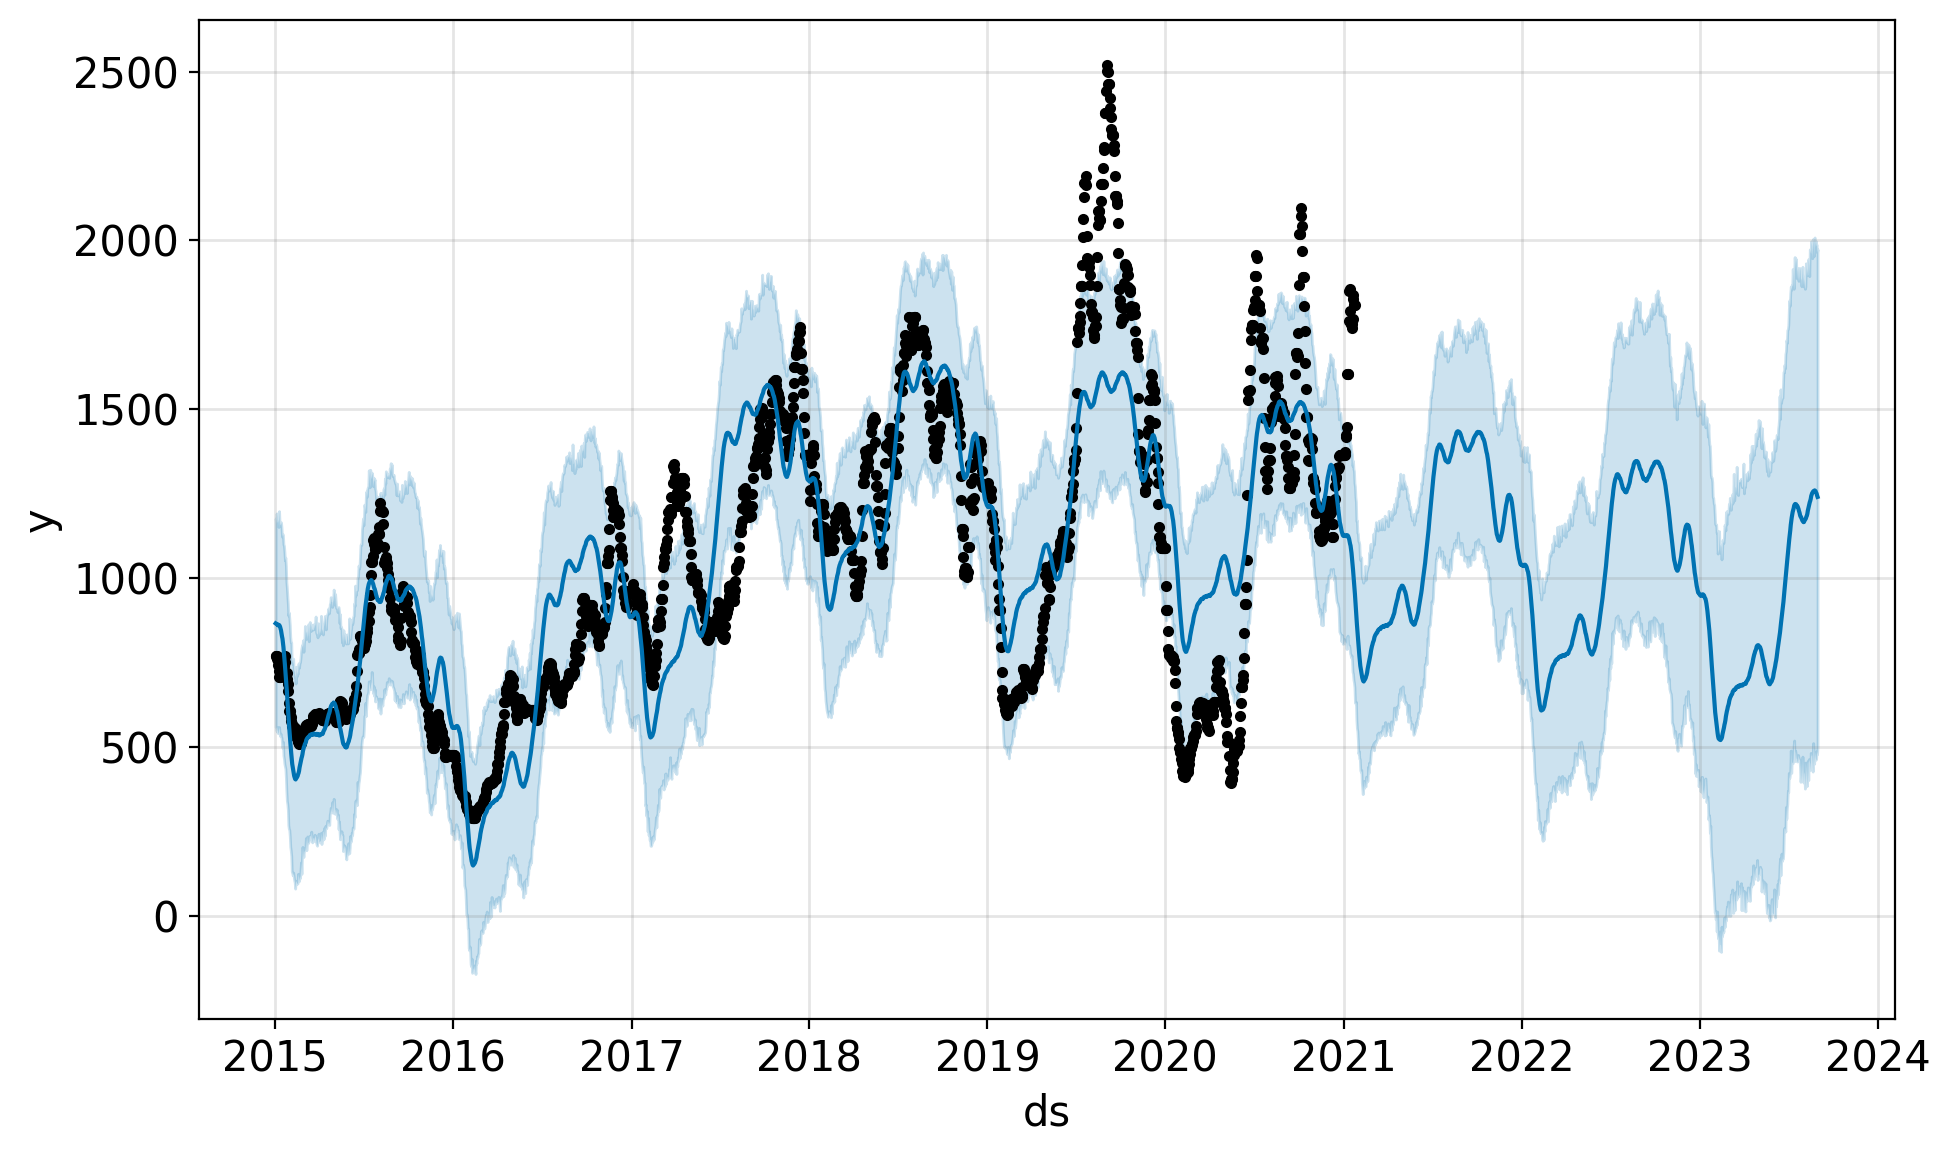

In [ ]:
m.plot(forecast)
from datetime import datetime
import matplotlib.pyplot as plt
# 구간 자세히 보기 (아래 해제)
# plt.xlim([datetime(2014, 1, 1), datetime(2014, 5, 30)])

### 시계열 컴포넌트 보기

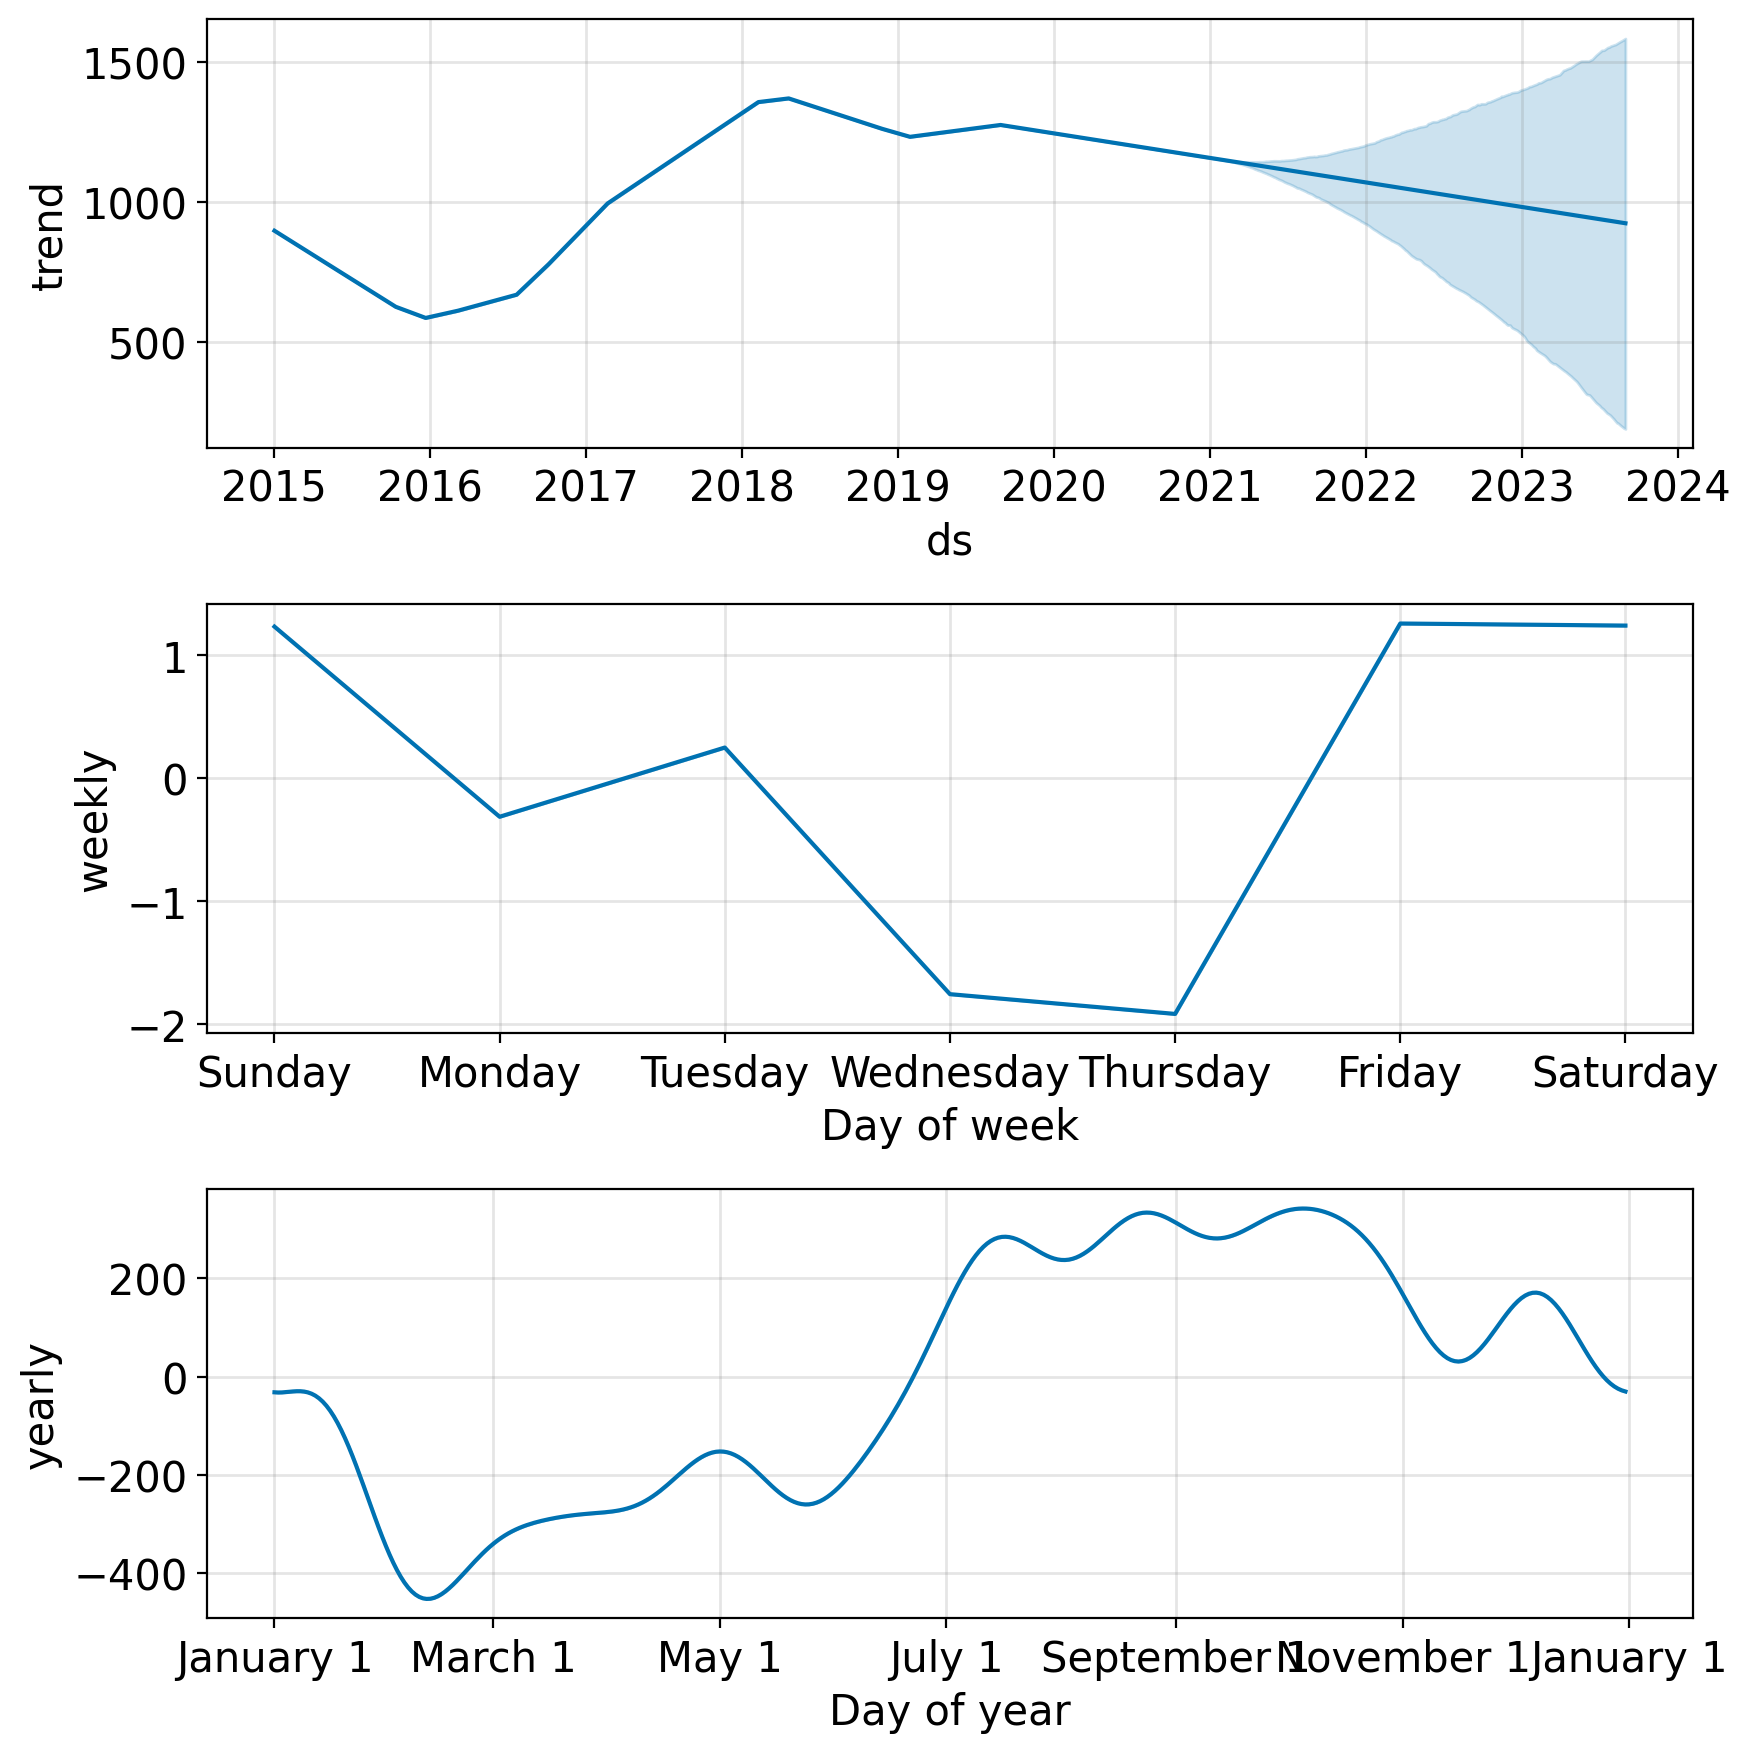

In [ ]:
_ = m.plot_components(forecast)

### 결과 성능 평가

In [ ]:
y_test = test_data.y
y_test.shape

(949,)

In [ ]:
y_pred = forecast[cut:].yhat
y_pred.shape

(949,)

In [ ]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

In [ ]:
def plot_reg_result(y_test, y_pred, N=50):
    y_t=y_test.ravel()
    y_p=y_pred.ravel()
    plt.plot(y_t[:N], 'r.-', label='y_test')
    plt.plot(y_p[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_t, y_t - y_p, s=5)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  4220.358
Mean Absolute Error:  1128.376
Root Mean Squared Error:  1434.113
R-Squared:  -1.032


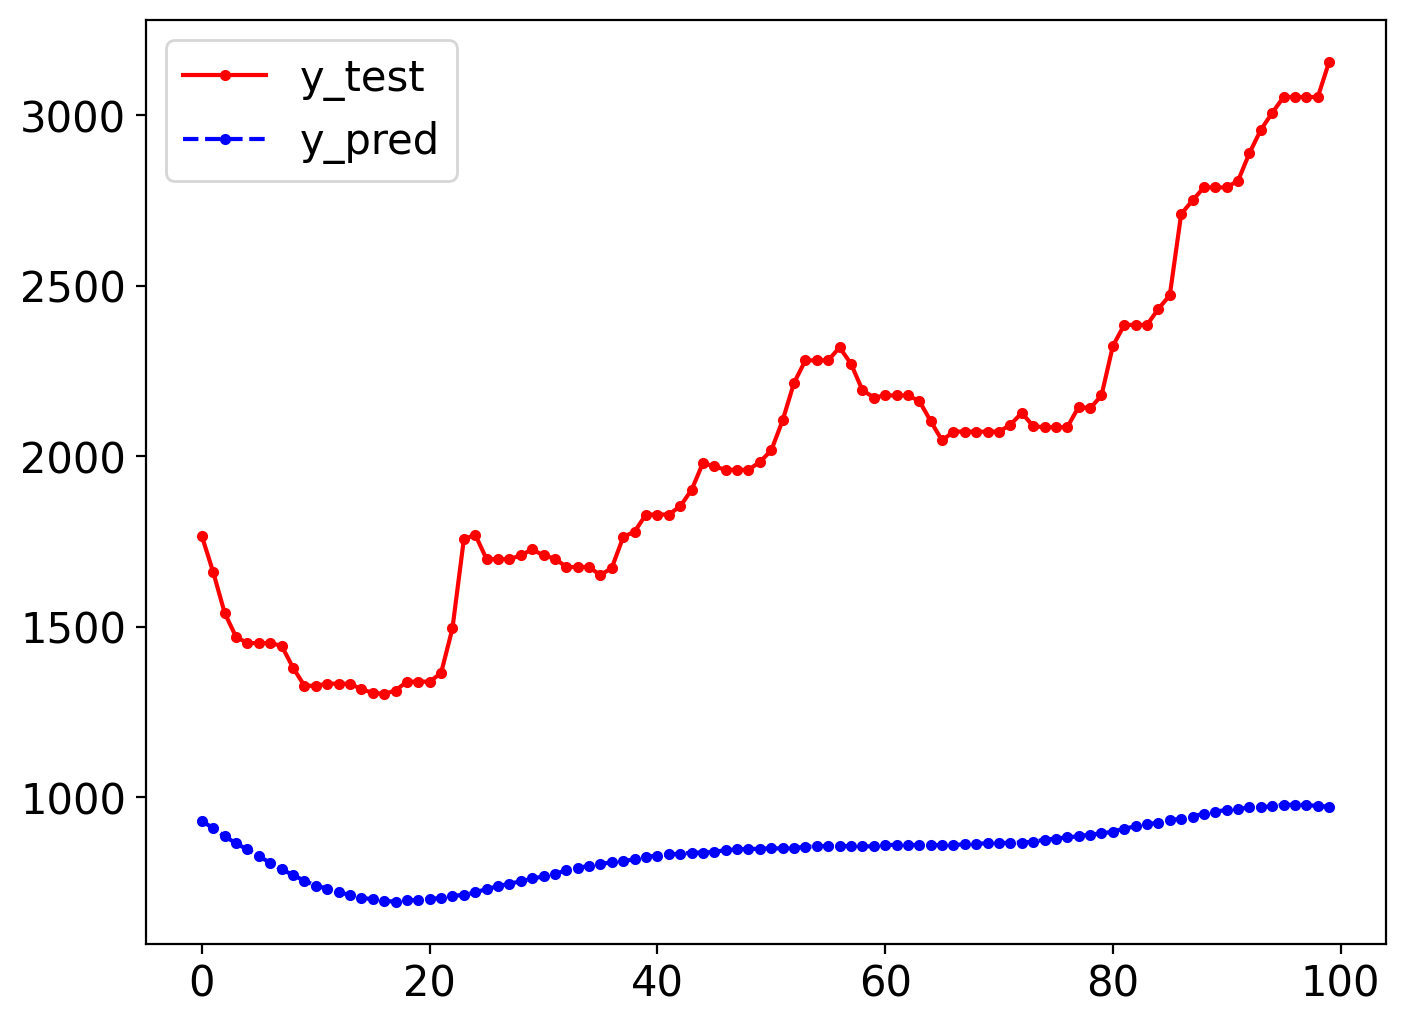

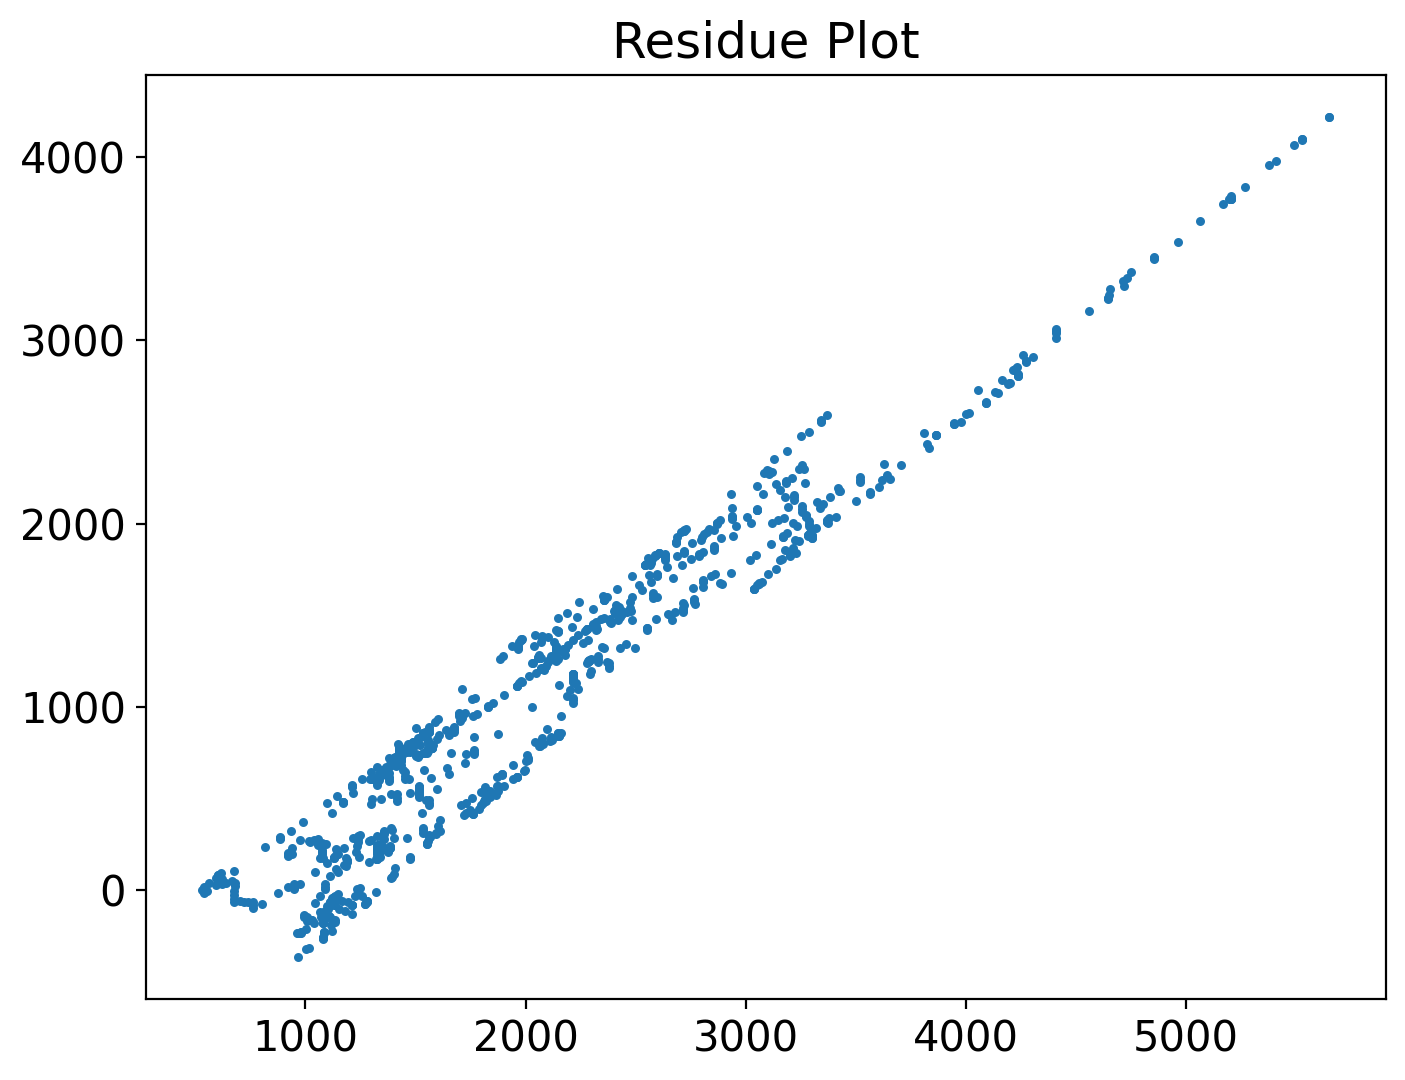

In [ ]:
plot_reg_result(y_test, y_pred, 100)

## (연습) 훈련 데이터로 950개를 사용하는 모델을 만드시오

In [ ]:
# (풀이)



# 자동차 판매량 예측

## 데이터

In [ ]:
path = 'https://raw.githubusercontent.com/StillWork/data/master/car_sales.csv'
car = pd.read_csv(path)
print(car.shape)
car[:3]

(108, 2)


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026


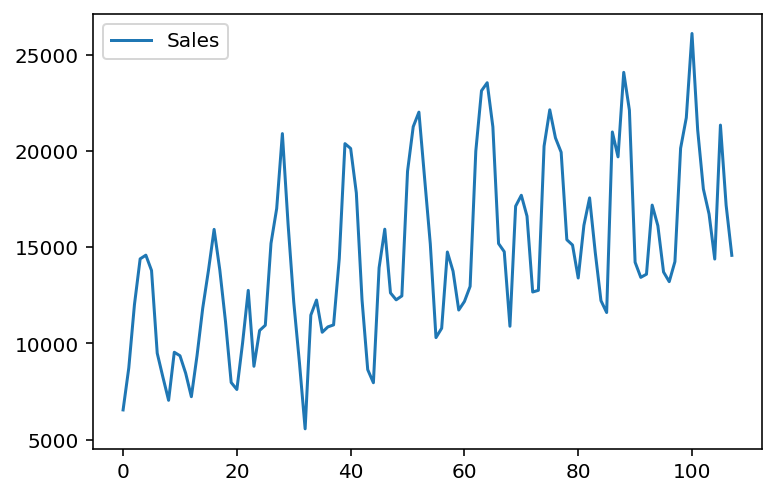

In [ ]:
car.plot()

In [ ]:
car.columns = ['ds', 'y']
car['ds']= pd.to_datetime(car['ds'])
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [ ]:
car[:3]

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026


### 훈련과 검증 데이터
- 최종 1년 데이터를 test 데이터로 사용

In [ ]:
df = car.copy()
train_data = df[:-12]
test_data = df[-12:]

## 모델 학습과 예측 수행

In [ ]:
all_range = df.drop("y", axis=1)
all_range

,ds
0,1960-01-01
1,1960-02-01
2,1960-03-01
3,1960-04-01
4,1960-05-01
...,...
103,1968-08-01
104,1968-09-01
105,1968-10-01
106,1968-11-01


In [ ]:
model = Prophet()
model.fit(train_data)

forecast = model.predict(all_range)
y_pred = forecast[-12:]['yhat'].values
y_test = test_data['y'].values

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 결과 보기

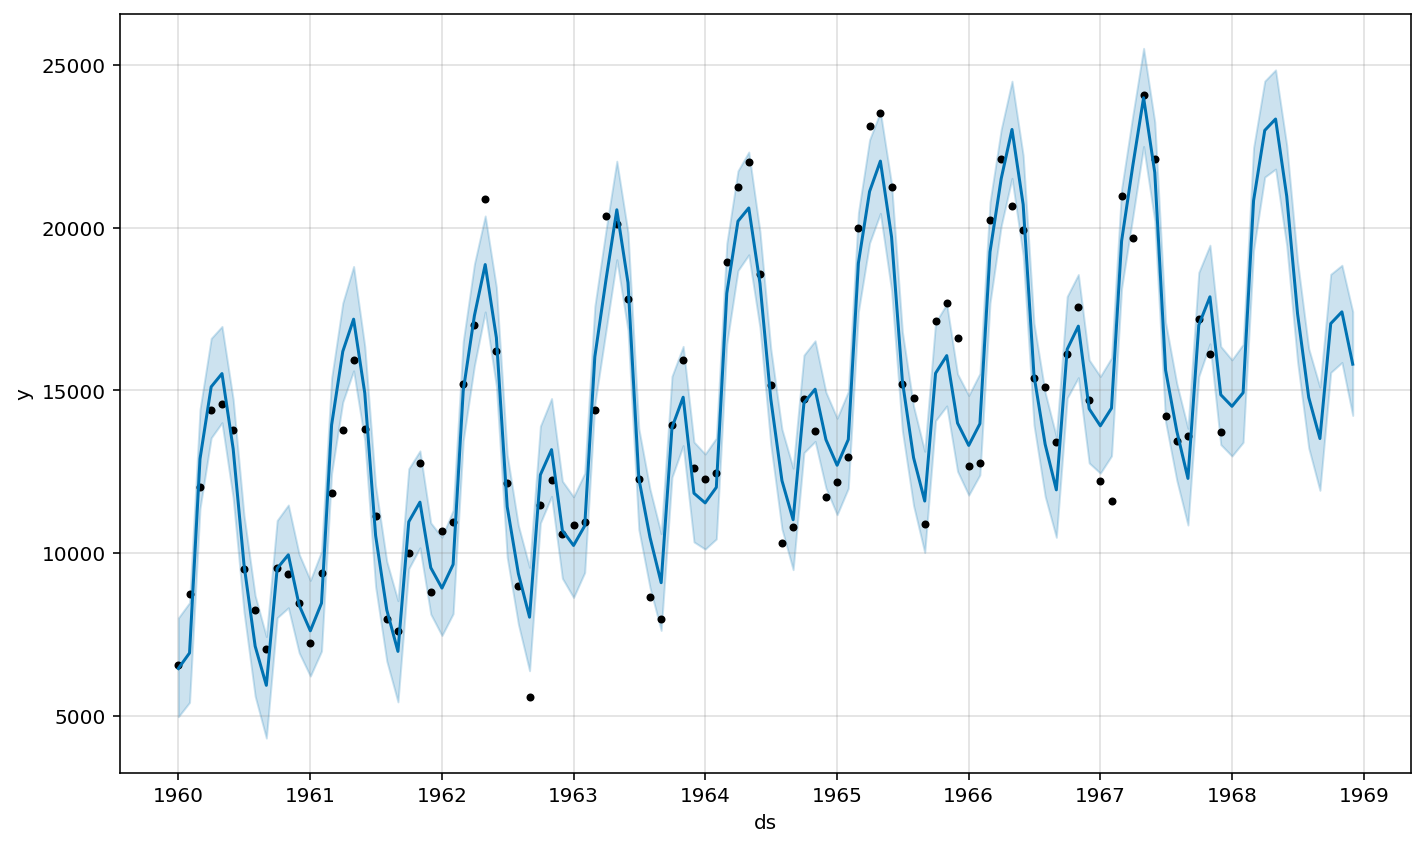

In [ ]:
_ = model.plot(forecast)

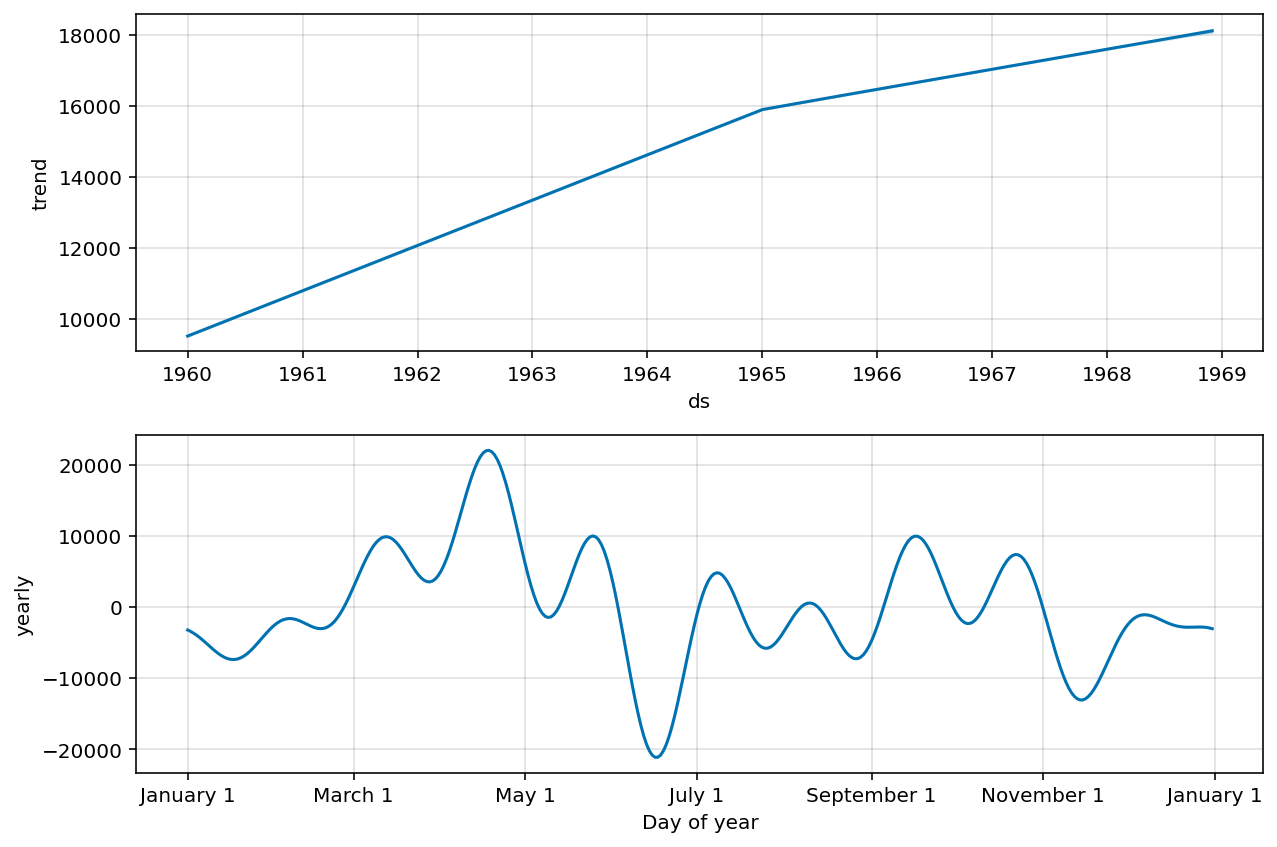

In [ ]:
_ = model.plot_components(forecast)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  4283.967
Mean Absolute Error:  1336.814
Root Mean Squared Error:  1749.191
R-Squared:  0.782


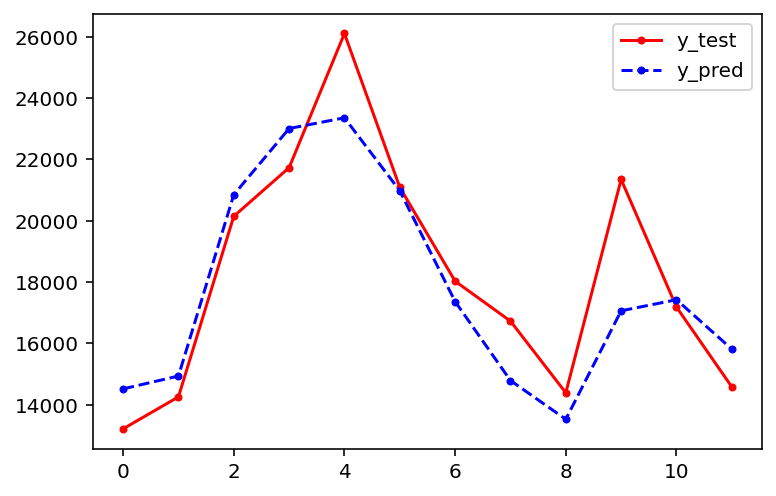

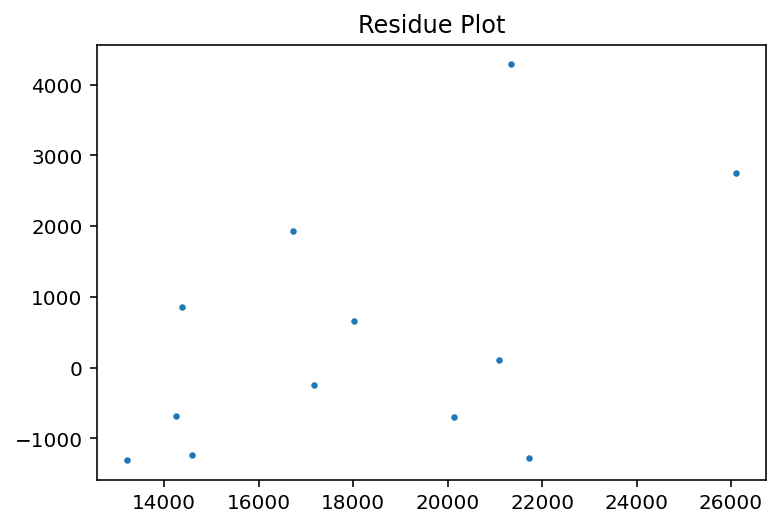

In [ ]:
plot_reg_result(y_test,y_pred)

## (연습) 자동차 판매 데이터에서 최근 2년치를 예측하는 모델을 만드시오

In [ ]:
# (풀이)



# 정답

## (연습) 훈련 데이터로 950개를 사용하는 모델을 만드시오

In [ ]:
df = power.resample('D').sum()
df.reset_index(inplace=True)
df.drop('temp', axis=1, inplace=True)
df.columns = ['ds','y']
cut = 950
train_data = df[:cut]
test_data = df[cut:]
m = Prophet()
m.fit(train_data)
all_range = df.copy()
all_range.drop('y', axis=1, inplace=True)
forecast = m.predict(all_range)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
y_test = test_data.y
y_pred = forecast[cut:].yhat
show_reg_result(y_test,y_pred)

Max Error:  16154.277
Mean Absolute Error:  5263.559
Root Mean Squared Error:  6046.279
R-Squared:  -0.212


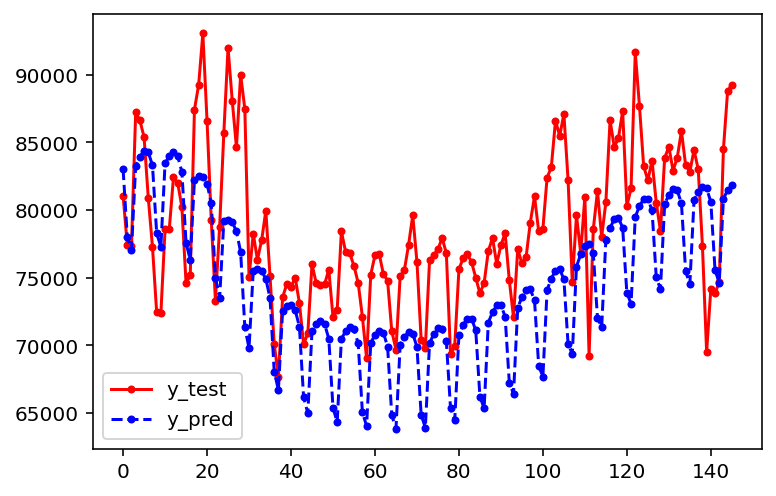

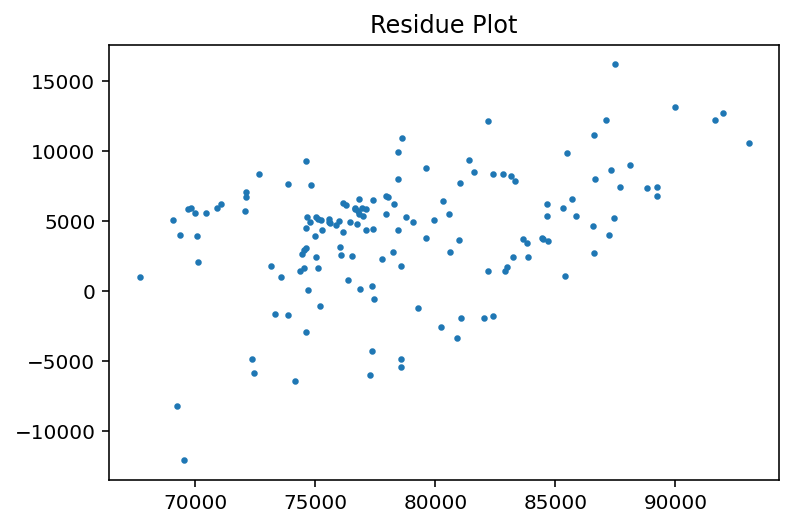

In [ ]:
plot_reg_result(y_test,y_pred,500)

## (연습) 자동차 판매 데이터에서 최근 2년치를 예측하는 모델을 만드시오

In [ ]:
df = car.copy()
train_data = df[:-24]
test_data = df[-24:]
all_range = df.drop("y", axis=1)
model = Prophet()
model.fit(train_data)

forecast = model.predict(all_range)
y_pred = forecast[-24:]['yhat'].values
y_test = test_data['y'].values


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


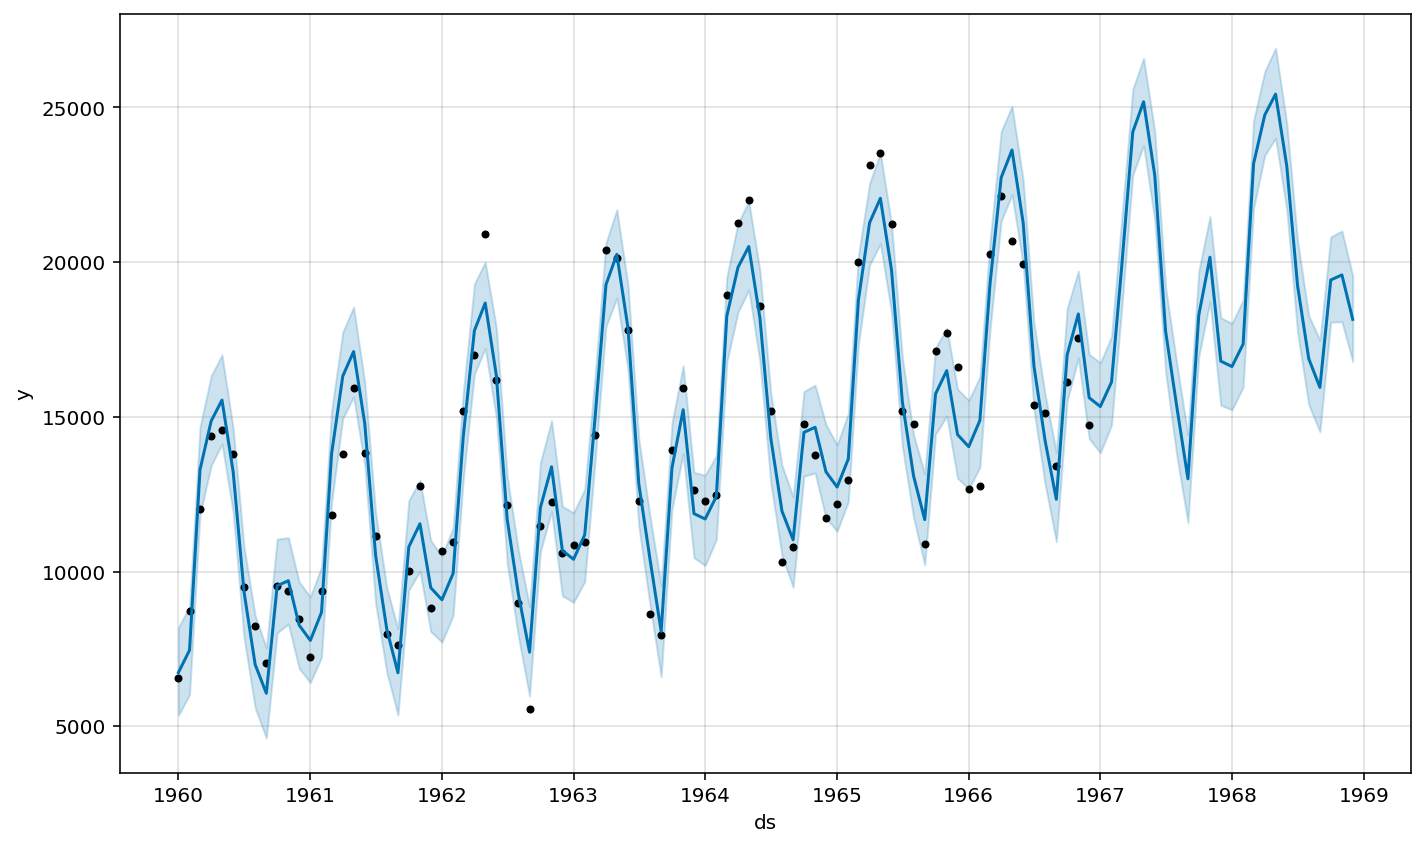

In [ ]:
_ = model.plot(forecast)

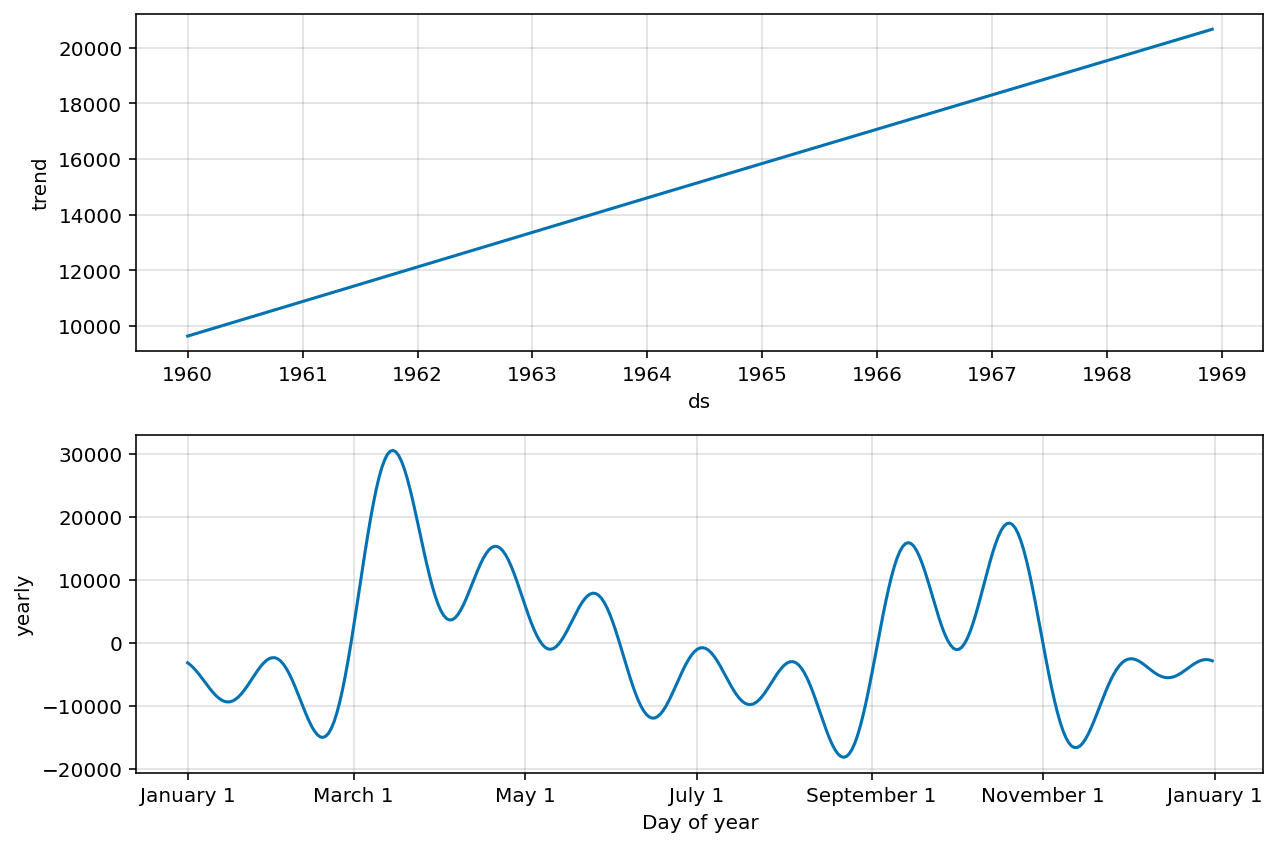

In [ ]:
_ = model.plot_components(forecast)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  4515.65
Mean Absolute Error:  2311.457
Root Mean Squared Error:  2641.612
R-Squared:  0.556


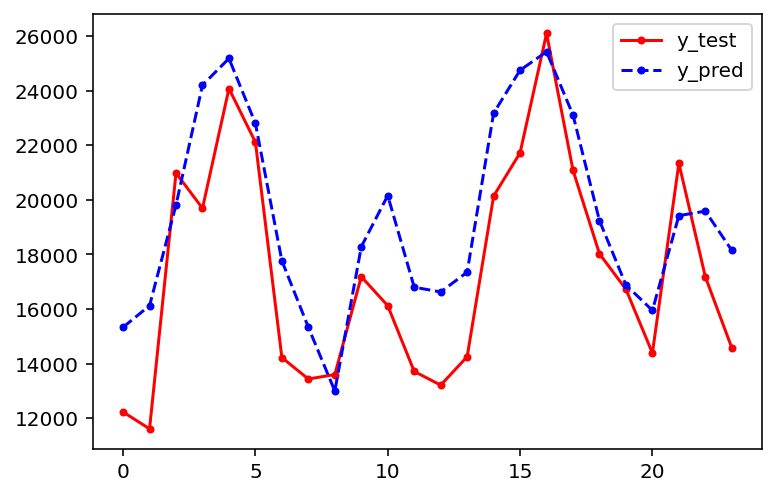

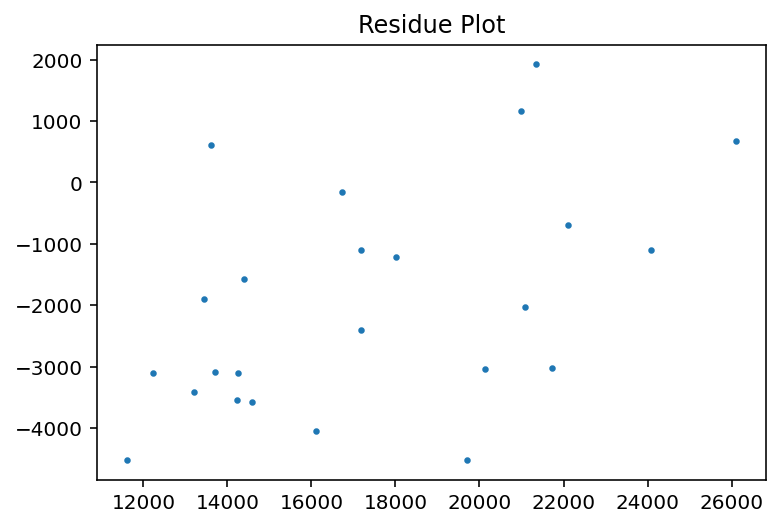

In [ ]:
plot_reg_result(y_test, y_pred, N=100)